In [19]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from bs4 import BeautifulSoup


1 - 45 Университет Дружбы народов

46 - 69 Генерала Тюленева

70 - 91 Генерала Тюленева + Тютчевская

In [20]:
urls_prices = [
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1697035&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=34441&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56706&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1699412&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1696612&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=66794&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18008&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1704160&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1694758&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1728408&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=27554&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=27549&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58839&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56710&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=71098&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=47492&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18008&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=989953&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1697035&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=71097&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=71098&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=71099&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=3245139&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18007&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58805&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18008&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1080888&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56706&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56705&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56710&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=47490&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18000&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17997&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=606455&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1701671&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17998&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=32592&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58801&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1711316&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58806&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58795&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1695695&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1704160&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18013&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79556&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79557&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1713733&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1715736&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1704699&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79567&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79561&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79525&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79570&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79569&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79572&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79539&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1703841&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1696643&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17957&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1715434&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17956&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1724532&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1703284&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1695949&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1700137&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1781723&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=606384&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17945&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1691421&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=41145&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1702798&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1713741&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1695987&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=41147&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79549&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79540&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79533&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79548&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79547&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79545&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=41159&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=41162&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=41165&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1847202&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1803888&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1833802&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1873062&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1807554&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1864728&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1813861&roomsCount=all&period=all",

    ]

In [21]:
urls_house_info = [
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+6&totalArea=38.4&roomsCount=1&offerId=309089270&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%91%D1%83%D1%82%D0%BB%D0%B5%D1%80%D0%BE%D0%B2%D0%B0%2C+2%D0%9A1&totalArea=60.0&roomsCount=3&offerId=311850058&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A3&totalArea=52.5&roomsCount=3&offerId=307635407&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+11&totalArea=96.3&roomsCount=4&offerId=308499030&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C+20&totalArea=63.1&roomsCount=3&offerId=309831811&floor=floorOne&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%9F%D1%80%D0%BE%D1%84%D1%81%D0%BE%D1%8E%D0%B7%D0%BD%D0%B0%D1%8F+%D1%83%D0%BB%D0%B8%D1%86%D0%B0%2C+96%D0%9A4&totalArea=32.0&roomsCount=1&offerId=311040447&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+25%D0%9A1&totalArea=33.0&roomsCount=1&offerId=307458577&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+5&totalArea=70.5&roomsCount=2&offerId=311731437&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%91%D1%83%D1%82%D0%BB%D0%B5%D1%80%D0%BE%D0%B2%D0%B0%2C+4&totalArea=58.0&roomsCount=2&offerId=311526699&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%91%D0%B0%D0%BA%D1%83%D0%BB%D0%B5%D0%B2%D0%B0%2C+2&totalArea=53.0&roomsCount=2&offerId=312002808&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%9B%D0%B5%D0%BD%D0%B8%D0%BD%D1%81%D0%BA%D0%B8%D0%B9+%D0%BF%D1%80%D0%BE%D1%81%D0%BF%D0%B5%D0%BA%D1%82%2C+150&totalArea=75.0&roomsCount=3&offerId=311108810&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%9B%D0%B5%D0%BD%D0%B8%D0%BD%D1%81%D0%BA%D0%B8%D0%B9+%D0%BF%D1%80%D0%BE%D1%81%D0%BF%D0%B5%D0%BA%D1%82%2C+144%D0%9A5&totalArea=58.9&roomsCount=2&offerId=308360830&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+23%D0%9A2&totalArea=58.9&roomsCount=3&offerId=310168643&floor=floorLast&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A7&totalArea=75.9&roomsCount=3&offerId=310793059&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+4%D0%9A3&totalArea=81.1&roomsCount=3&offerId=309936581&floor=floorOne&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%9C%D0%B8%D0%BA%D0%BB%D1%83%D1%85%D0%BE-%D0%9C%D0%B0%D0%BA%D0%BB%D0%B0%D1%8F+%D1%83%D0%BB%D0%B8%D1%86%D0%B0%2C+27%D0%9A1&totalArea=73.8&roomsCount=3&offerId=308129789&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+25%D0%9A1&totalArea=63.5&roomsCount=3&offerId=311563032&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+8%D0%BA3&totalArea=58.0&roomsCount=2&offerId=309527570&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+6&totalArea=38.4&roomsCount=1&offerId=307713412&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+4%D0%9A2&totalArea=79.5&roomsCount=3&offerId=309254865&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+4%D0%9A3&totalArea=81.1&roomsCount=3&offerId=309936581&floor=floorOne&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+4%D0%9A4&totalArea=55.2&roomsCount=2&offerId=308290049&floor=floorLast&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+2%D0%90&totalArea=120.0&roomsCount=3&offerId=309980787&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+23%D0%9A1&totalArea=60.0&roomsCount=3&offerId=306765780&floor=floorOne&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+9%D0%9A4&totalArea=39.0&roomsCount=1&offerId=307912564&floor=floorLast&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+25%D0%9A1&totalArea=33.0&roomsCount=1&offerId=307458577&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%BA6&totalArea=41.0&roomsCount=1&offerId=311945204&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A3&totalArea=52.5&roomsCount=3&offerId=307635407&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A2&totalArea=71.6&roomsCount=4&offerId=311912659&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A7&totalArea=75.9&roomsCount=3&offerId=310793059&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%9C%D0%B8%D0%BA%D0%BB%D1%83%D1%85%D0%BE-%D0%9C%D0%B0%D0%BA%D0%BB%D0%B0%D1%8F+%D1%83%D0%BB%D0%B8%D1%86%D0%B0%2C+25&totalArea=38.7&roomsCount=1&offerId=310270512&floor=floorLast&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+15%D0%9A3&totalArea=66.4&roomsCount=3&offerId=311328806&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+15%D0%9A1&totalArea=63.0&roomsCount=3&offerId=300302109&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+8%D0%90&totalArea=95.1&roomsCount=3&offerId=311908456&floor=floorTwo&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+13&totalArea=45.3&roomsCount=2&offerId=307780981&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+15%D0%9A2&totalArea=45.0&roomsCount=2&offerId=299209036&floor=floorTwo&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C+2%D0%9A1&totalArea=40.0&roomsCount=1&offerId=309589901&floor=floorTwo&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+9%D0%9A1&totalArea=52.5&roomsCount=1&offerId=308770205&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C+8&totalArea=45.8&roomsCount=2&offerId=311262176&floor=floorLast&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+9%D0%9A5&totalArea=120.0&roomsCount=3&offerId=303870632&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+5%D0%9A3&totalArea=51.0&roomsCount=1&offerId=311125656&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+9&totalArea=66.6&roomsCount=2&offerId=311234104&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+5&totalArea=70.5&roomsCount=2&offerId=312077134&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+31%D0%9A2&totalArea=64.0&roomsCount=3&offerId=310639393&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+21%D0%9A1&totalArea=75.0&roomsCount=3&offerId=303230896&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+21%D0%9A2&totalArea=26.0&roomsCount=1&offerId=308076419&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+4&totalArea=50.6&roomsCount=2&offerId=310662654&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+8&totalArea=59.0&roomsCount=3&offerId=310505447&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+23&totalArea=36.8&roomsCount=1&offerId=311772311&floor=floorLast&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+25%D0%9A1&totalArea=37.6&roomsCount=1&offerId=310947195&floor=floorLast&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+21%D0%9A5&totalArea=45.2&roomsCount=2&offerId=312120809&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+12%D0%9A1&totalArea=38.5&roomsCount=2&offerId=310625201&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+25%D0%9A5&totalArea=45.0&roomsCount=2&offerId=308637655&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+25%D0%9A4&totalArea=62.0&roomsCount=3&offerId=288824068&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+27&totalArea=54.0&roomsCount=2&offerId=311120890&floor=floorLast&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+14%2F2&totalArea=44.4&roomsCount=2&offerId=301200222&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+5&totalArea=76.2&roomsCount=4&offerId=308144018&floor=floorOne&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+3&totalArea=60.8&roomsCount=3&offerId=302971287&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C+4%D0%9A2&totalArea=40.0&roomsCount=2&offerId=310967629&floor=floorOther",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C+6&totalArea=60.0&roomsCount=3&offerId=308397152&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C+4%D0%9A1&totalArea=34.1&roomsCount=1&offerId=305930485&floor=floorOne&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C+12&totalArea=50.8&roomsCount=2&offerId=304858455&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C+1&totalArea=102.2&roomsCount=3&offerId=311371966&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+6&totalArea=45.2&roomsCount=2&offerId=308908363&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+2&totalArea=32.5&roomsCount=1&offerId=312295732&floor=floorOne&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+8&totalArea=65.6&roomsCount=3&offerId=312454781&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+28&totalArea=32.6&roomsCount=1&offerId=307775309&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+36&totalArea=73.4&roomsCount=3&offerId=311208660&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+11&totalArea=64.0&roomsCount=3&offerId=310743428&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+7%D0%9A1&totalArea=61.0&roomsCount=3&offerId=311126074&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+13&totalArea=68.0&roomsCount=3&offerId=304856437&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+15&totalArea=51.3&roomsCount=2&offerId=311160192&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+17&totalArea=51.0&roomsCount=2&offerId=302404390&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+7%D0%9A2&totalArea=34.7&roomsCount=1&offerId=308231609&floor=floorTwo&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+15%D0%9A7&totalArea=52.0&roomsCount=2&offerId=309113077&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+15%D0%9A1&totalArea=63.5&roomsCount=2&offerId=301855337&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+13%D0%9A1&totalArea=58.8&roomsCount=2&offerId=308746096&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+15%D0%9A6&totalArea=51.5&roomsCount=2&offerId=309117903&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+15%D0%9A5&totalArea=61.5&roomsCount=3&offerId=294319016&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+15%D0%9A4&totalArea=34.8&roomsCount=1&offerId=312464277&floor=floorOne&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+25&totalArea=51.5&roomsCount=2&offerId=309890288&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+27&totalArea=51.0&roomsCount=2&offerId=312472389&floor=floorTwo&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+29%D0%9A2&totalArea=40.0&roomsCount=1&offerId=311777987&floor=floorTwo&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D1%80%D0%BE%D1%8F+%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8+%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C+1&totalArea=67.4&roomsCount=2&offerId=309636118&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D1%80%D0%BE%D1%8F+%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8+%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C+18&totalArea=50.5&roomsCount=1&offerId=310314749&floor=floorTwo&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+35&totalArea=54.0&roomsCount=1&offerId=312231467&floor=floorTwo&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+31&totalArea=44.9&roomsCount=2&offerId=308567781&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+33&totalArea=51.4&roomsCount=2&offerId=303243667&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+28&totalArea=33.3&roomsCount=1&offerId=307890576&floor=floorTwo&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+29&totalArea=33.9&roomsCount=1&offerId=311586464&floor=floorOther&repairType=repairTypeWithout",
    
]   

In [42]:
urls_metro = [
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%206",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%91%D1%83%D1%82%D0%BB%D0%B5%D1%80%D0%BE%D0%B2%D0%B0%2C%202%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%9A3",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%2011",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C%2020",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%9F%D1%80%D0%BE%D1%84%D1%81%D0%BE%D1%8E%D0%B7%D0%BD%D0%B0%D1%8F%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%2C%2096%D0%9A4",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2025%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%205",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%91%D1%83%D1%82%D0%BB%D0%B5%D1%80%D0%BE%D0%B2%D0%B0%2C%204",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%91%D0%B0%D0%BA%D1%83%D0%BB%D0%B5%D0%B2%D0%B0%2C%202",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%9B%D0%B5%D0%BD%D0%B8%D0%BD%D1%81%D0%BA%D0%B8%D0%B9%20%D0%BF%D1%80%D0%BE%D1%81%D0%BF%D0%B5%D0%BA%D1%82%2C%20150",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%9B%D0%B5%D0%BD%D0%B8%D0%BD%D1%81%D0%BA%D0%B8%D0%B9%20%D0%BF%D1%80%D0%BE%D1%81%D0%BF%D0%B5%D0%BA%D1%82%2C%20144%D0%9A5",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%2023%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%9A7",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%204%D0%9A3",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%9C%D0%B8%D0%BA%D0%BB%D1%83%D1%85%D0%BE-%D0%9C%D0%B0%D0%BA%D0%BB%D0%B0%D1%8F%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%2C%2027%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2025%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%208%D0%BA3",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%206",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%204%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%204%D0%9A3",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%204%D0%9A4",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%202%D0%90",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2023%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%209%D0%9A4",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2025%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%BA6",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%9A3",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%9A7",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%9C%D0%B8%D0%BA%D0%BB%D1%83%D1%85%D0%BE-%D0%9C%D0%B0%D0%BA%D0%BB%D0%B0%D1%8F%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%2C%2025",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2015%D0%9A3",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2015%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%208%D0%90",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2013",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2015%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C%202%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%209%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C%208",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%209%D0%9A5",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%205%D0%9A3",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%209",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%205",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2031%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2021%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2021%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%204",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%208",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2023",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2025%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2021%D0%9A5",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2012%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2025%D0%9A5",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2025%D0%9A4",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2027",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2014%2F2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%205",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%203",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C%204%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C%206",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C%204%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C%2012",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C%201",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%206",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%202",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%208",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%2028",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%2036",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2011",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%207%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2013",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2015",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2017",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%207%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2015%D0%9A7",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2015%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2013%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2015%D0%9A6",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2015%D0%9A5",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2015%D0%9A4",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2025",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2027",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2029%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D1%80%D0%BE%D1%8F%20%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8%20%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C%201",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D1%80%D0%BE%D1%8F%20%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8%20%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C%2018",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2035",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2031",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2033",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2028",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2029",

]

## Парсим цены

In [23]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

all_data = []

def fetch_and_process_url(url, realty_id):
    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            data = response.json()  
            if 'houseTrand' in data:
                trend_data = pd.DataFrame(data['houseTrand'])
                trend_data['value'] = trend_data['value'].astype(float)
                trend_data['reportDate'] = pd.to_datetime(trend_data['reportDate'])
                trend_data['realty_id'] = realty_id 
                return trend_data
            else:
                print(f"Ключ 'houseTrand' отсутствует в ответе для {url}")
        else:
            print(f"Ошибка {response.status_code} при запросе {url}")
    except requests.RequestException as e:
        print(f"Ошибка при запросе {url}: {e}")
    return None

for idx, url in enumerate(urls_prices, start=1):
    print(f"Обработка ссылки {idx}/{len(urls_prices)}: {url}")
    trend_data = fetch_and_process_url(url, realty_id=idx)
    if trend_data is not None:
        all_data.append(trend_data)
    
    pause = random.uniform(20, 25)
    print(f"Пауза {pause:.2f} секунд...")
    time.sleep(pause)

if all_data:
    prices_data = pd.concat(all_data, ignore_index=True)
    prices_data

Обработка ссылки 1/90: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1697035&roomsCount=all&period=all
Пауза 22.30 секунд...
Обработка ссылки 2/90: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=34441&roomsCount=all&period=all
Пауза 24.19 секунд...
Обработка ссылки 3/90: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56706&roomsCount=all&period=all
Пауза 22.47 секунд...
Обработка ссылки 4/90: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1699412&roomsCount=all&period=all
Пауза 22.69 секунд...
Обработка ссылки 5/90: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1696612&roomsCount=all&period=all
Пауза 24.82 секунд...
Обработка ссылки 6/90: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=66794&roomsCount=all&period=all
Пауза 21.82 секунд...
Обработка ссылки 7/90: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?

In [24]:
prices_data.head()

,value,reportDate,prettyValue,realty_id
0,207595.0,2020-02-01,207 595 ₽/м²,1
1,220493.0,2020-03-01,220 493 ₽/м²,1
2,228764.0,2020-04-01,228 764 ₽/м²,1
3,228764.0,2020-05-01,228 764 ₽/м²,1
4,239315.0,2020-06-01,239 315 ₽/м²,1


In [25]:
prices_data.to_csv("prices_data.csv", index=False)

<hr>

## Парсим характеристики дома

In [26]:
columns = [
    "realty_id", "Адрес", "Год постройки", "Тип дома", "Этажность", "Строительная серия", "Высота потолков",
    "Газоснабжение", "Отопление", "Тип перекрытий", "Подъездов", "Количество лифтов",
    "Мусоропроводов", "Квартир", "Реновация", "Аварийность", "Детская площадка",
    "Спортивная площадка", "Фонд капитального ремонта", "URL"
]
data_house_features = pd.DataFrame(columns=columns)


def parse_page(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code != 200:
            print(f"Ошибка загрузки страницы: {response.status_code} для {url}")
            return None

        soup = BeautifulSoup(response.text, "html.parser")


        address_block = soup.find("span", class_="f0b5faa8cb--color_gray60_100--mYFjS")
        address = address_block.text.strip() if address_block else "Адрес не найден"

        name_blocks = soup.find_all("div", class_="f0b5faa8cb--name--vfsqB")
        value_blocks = soup.find_all("div", class_="f0b5faa8cb--val--YiBYQ")

        if len(name_blocks) == len(value_blocks):
            data = {"Адрес": address, "URL": url}  
            for name, value in zip(name_blocks, value_blocks):
                key = name.text.strip()
                val = value.text.strip()
                data[key] = val
            return data
        else:
            print(f"Количество названий и значений не совпадает для {url}.")
            return None
    except requests.RequestException as e:
        print(f"Ошибка при запросе {url}: {e}")
        return None


parsed_data_list = []
for idx, url in enumerate(urls_house_info, start=1): 
    print(f"Обработка {idx}/{len(urls_house_info)}: {url}")
    parsed_data = parse_page(url)
    if parsed_data:
        parsed_data["realty_id"] = idx  
        
        for col in columns:
            if col not in parsed_data:
                parsed_data[col] = None
        parsed_data_list.append(parsed_data)
    
   
    pause = random.uniform(20, 25)
    print(f"Пауза {pause:.2f} секунд...")
    time.sleep(pause)


if parsed_data_list:
    data_house_features = pd.concat([pd.DataFrame([data]) for data in parsed_data_list], ignore_index=True)
    print("Данные успешно собраны.")
else:
    print("Нет данных для объединения.")

Обработка 1/90: https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+6&totalArea=38.4&roomsCount=1&offerId=309089270&floor=floorOther&repairType=repairTypeDesign
Пауза 24.78 секунд...
Обработка 2/90: https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%91%D1%83%D1%82%D0%BB%D0%B5%D1%80%D0%BE%D0%B2%D0%B0%2C+2%D0%9A1&totalArea=60.0&roomsCount=3&offerId=311850058&floor=floorOther&repairType=repairTypeDesign
Пауза 21.87 секунд...
Обработка 3/90: https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A3&totalArea=52.5&roomsCount=3&offerId=307635407&floor=floorOther&repairType=repairTypeWithout
Пауза 21.50 секунд...
Обработка 4/90: https://www.c

In [27]:
data_house_features.head()

,Адрес,URL,Год постройки,Тип дома,Этажность,Строительная серия,Высота потолков,Газоснабжение,Отопление,Тип перекрытий,Подъездов,Количество лифтов,Мусоропроводов,Квартир,Реновация,Аварийность,Детская площадка,Спортивная площадка,Фонд капитального ремонта,realty_id
0,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,2.64,Отсутствует,Центральное,Другие,2,"4 пассажирских, 2 грузовых",2,166,Нет,Нет,Нет,Нет,На счете регионального оператора,1
1,"Москва, улица Бутлерова, 2К1",https://www.cian.ru/kalkulator-nedvizhimosti/?...,1967,Монолитный,9,None,2.5,Центральное,Центральное,Железобетонные,4,4 пассажирских,4,144,Нет,Нет,Да,Да,На специальном счете у регионального оператора,2
2,"Москва, улица Обручева, 28К3",https://www.cian.ru/kalkulator-nedvizhimosti/?...,1966,None,16,None,2.65,Отсутствует,Центральное,Железобетонные,1,"1 пассажирский, 1 грузовой",1,111,Нет,Нет,Нет,Нет,На счете регионального оператора,3
3,"Москва, улица Островитянова, 11",https://www.cian.ru/kalkulator-nedvizhimosti/?...,1999,Панельный,17,П-3М,2.64,Отсутствует,Центральное,Железобетонные,5,"5 пассажирских, 5 грузовых",5,320,Нет,Нет,Нет,Да,На специальном счете у регионального оператора,4
4,"Москва, улица Академика Арцимовича, 20",https://www.cian.ru/kalkulator-nedvizhimosti/?...,1968,Панельный,9,II-57,2.64,Центральное,Центральное,Железобетонные,7,7 пассажирских,7,251,Нет,Нет,Да,Да,На специальном счете у регионального оператора,5


In [28]:
data_house_features.to_csv("house_features.csv", index=False)

## Парсим расстояние до метро

In [43]:

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

all_metro_data = []


def fetch_and_process_metro(url, realty_id):
    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            data = response.json()  
            if 'metro' in data:  
                metro_list = data['metro']
                metro_data = []
                for metro in metro_list:
                    metro_data.append({
                        "Станция": metro["name"],
                        "Расстояние (м)": metro["distance"],
                        "Тип транспорта": "Пешком" if metro["travelType"] == "byFoot" else "На машине",
                        "Время в пути (мин)": metro["travelTime"],
                        "realty_id": realty_id
                    })
                return pd.DataFrame(metro_data)
            else:
                print(f"Ключ 'metro' отсутствует в ответе для {url}")
        else:
            print(f"Ошибка {response.status_code} при запросе {url}")
    except requests.RequestException as e:
        print(f"Ошибка при запросе {url}: {e}")
    return None

for idx, url in enumerate(urls_metro, start=1):
    print(f"Обработка ссылки {idx}/{len(urls_metro)}: {url}")
    metro_data = fetch_and_process_metro(url, realty_id=idx)
    if metro_data is not None:
        all_metro_data.append(metro_data)
    
    
    pause = random.uniform(20, 25)
    print(f"Пауза {pause:.2f} секунд...")
    time.sleep(pause)


if all_metro_data:
    metro_data = pd.concat(all_metro_data, ignore_index=True)
    print("Данные о метро успешно собраны.")
else:
    metro_data = pd.DataFrame()  
    print("Нет данных для объединения.")

print(metro_data)


Обработка ссылки 1/90: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%206
Пауза 22.85 секунд...
Обработка ссылки 2/90: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%91%D1%83%D1%82%D0%BB%D0%B5%D1%80%D0%BE%D0%B2%D0%B0%2C%202%D0%9A1
Пауза 22.22 секунд...
Обработка ссылки 3/90: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%9A3
Пауза 22.86 секунд...
Обработка ссылки 4/90: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E

In [44]:
metro_data.to_csv("metro_data.csv", index=False)

In [45]:
# Группируем по realtyId и выбираем 2 ближайшие станции
nearest_stations = (
    metro_data.sort_values(by=["realty_id", "Расстояние (м)"])
    .groupby("realty_id")
    .head(2)  # Берем две ближайшие станции
    .reset_index(drop=True)
)

# Преобразуем данные в нужный формат
result = nearest_stations.pivot_table(
    index="realty_id",
    values=["Расстояние (м)", "Станция"],
    aggfunc=lambda x: list(x)[:2]  # Берем значения для двух ближайших станций
).reset_index()

# Разделяем расстояния и названия станций по столбцам
result[["Расстояние до первой станции", "Расстояние до второй станции"]] = pd.DataFrame(result["Расстояние (м)"].tolist(), index=result.index)
result[["Название первой станции", "Название второй станции"]] = pd.DataFrame(result["Станция"].tolist(), index=result.index)

# Убираем лишние столбцы
metro_data_plus = result.drop(columns=["Расстояние (м)", "Станция"])

# Результат
print(metro_data_plus)


    realty_id  Расстояние до первой станции  Расстояние до второй станции  \
0           1                         881.0                        2370.0   
1           2                        1297.0                        1311.0   
2           3                         978.0                        1816.0   
3           4                        1450.0                        1516.0   
4           5                         944.0                        1266.0   
..        ...                           ...                           ...   
84         86                        1319.0                        1581.0   
85         87                        1353.0                        1579.0   
86         88                        1552.0                        3558.0   
87         89                        1597.0                        1603.0   
88         90                        1597.0                        1603.0   

       Название первой станции     Название второй станции  
0   Университе

In [50]:
metro_data_plus.shape

(89, 5)

In [47]:
merged_table = prices_data.merge(data_house_features, on='realty_id', how='left').merge(metro_data_plus, on='realty_id', how='left')

In [48]:
merged_table.to_csv("merged_table.csv", index=False)

In [35]:
merged_table = pd.read_csv("merged_table.csv")

In [59]:
lpr = pd.DataFrame()
lpr["value"] = merged_table["value"]
lpr["reportDate"] = merged_table.reportDate
lpr["Расстояние до первой станции"] = merged_table["Расстояние до первой станции"]
lpr['reportDate'] = pd.to_datetime(lpr['reportDate'])
lpr['treatment'] = (lpr['reportDate'] >= pd.to_datetime('2024-08-01')).astype(int)


In [60]:
lpr

,value,reportDate,Расстояние до первой станции,treatment
0,207595.0,2020-02-01,881.0,0
1,220493.0,2020-03-01,881.0,0
2,228764.0,2020-04-01,881.0,0
3,228764.0,2020-05-01,881.0,0
4,239315.0,2020-06-01,881.0,0
...,...,...,...,...
4118,215254.0,2024-08-01,1597.0,1
4119,215254.0,2024-09-01,1597.0,1
4120,249221.0,2024-10-01,1597.0,1
4121,235988.0,2024-11-01,1597.0,1


In [61]:
lpr_new = lpr.groupby(["treatment", "Расстояние до первой станции"])["value"].mean().reset_index()

data_treatment_0 = lpr_new[lpr_new.treatment == 0]
data_treatment_1 = lpr_new[lpr_new.treatment == 1]

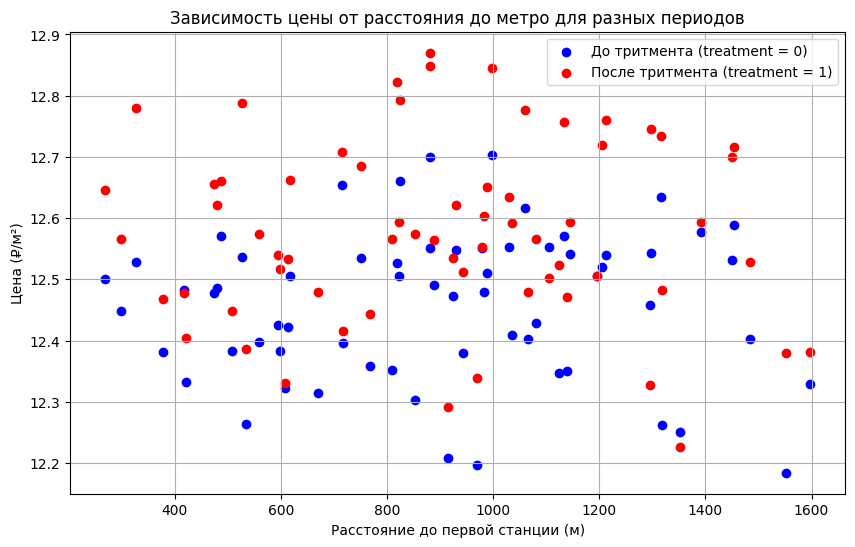

In [62]:
plt.figure(figsize=(10, 6))

# Линия для treatment = 0
plt.scatter(
    data_treatment_0['Расстояние до первой станции'],
    np.log(data_treatment_0['value']),
    color='blue',
    label='До тритмента (treatment = 0)'
)

# Линия для treatment = 1
plt.scatter(
    data_treatment_1['Расстояние до первой станции'],
    np.log(data_treatment_1['value']),
    color='red',
    label='После тритмента (treatment = 1)'
)

# Настройка графика
plt.xlabel('Расстояние до первой станции (м)')
plt.ylabel('Цена (₽/м²)')
plt.title('Зависимость цены от расстояния до метро для разных периодов')
plt.legend()
plt.grid()
plt.show()

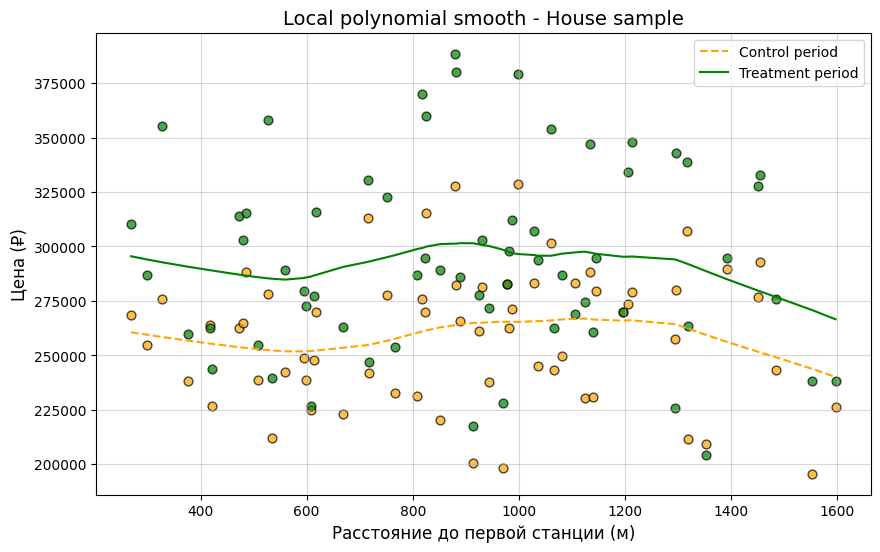

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess


# Преобразование reportDate в datetime
#lpr_new['reportDate'] = pd.to_datetime(lpr_new['reportDate'])

# Разделение на контрольный и тритмент-периоды
control = lpr_new[lpr_new['treatment'] == 0]
treatment = lpr_new[lpr_new['treatment'] == 1]

# Сглаживание LOWESS
lowess_control = lowess(control['value'], control['Расстояние до первой станции'], frac=0.5)
lowess_treatment = lowess(treatment['value'], treatment['Расстояние до первой станции'], frac=0.5)

# Построение графика
plt.figure(figsize=(10, 6))

# Контрольный период
plt.plot(lowess_control[:, 0], lowess_control[:, 1], color='orange', label='Control period', linestyle='--')
plt.scatter(control['Расстояние до первой станции'], control['value'], color='orange', edgecolor='black', s=40, alpha=0.7)

# Период тритмента
plt.plot(lowess_treatment[:, 0], lowess_treatment[:, 1], color='green', label='Treatment period', linestyle='-')
plt.scatter(treatment['Расстояние до первой станции'], treatment['value'], color='green', edgecolor='black', s=40, alpha=0.7)

# Оформление
plt.xlabel('Расстояние до первой станции (м)', fontsize=12)
plt.ylabel('Цена (₽)', fontsize=12)
plt.title('Local polynomial smooth - House sample', fontsize=14)
plt.legend()
plt.grid(alpha=0.5)
plt.show()
